# Configure SBS Parameters

This notebook should be used as a test for ensuring correct SBS image loading and processing before running the SBS module.
Cells marked with <font color='red'>SET PARAMETERS</font> contain crucial variables that need to be set according to your specific experimental setup and data organization.
Please review and modify these variables as needed before proceeding with the analysis.

## <font color='red'>SET PARAMETERS</font>

### Fixed parameters for SBS processing

- `CONFIG_FILE_PATH`: Path to a Brieflow config file used during processing. Absolute or relative to where workflows are run from.

In [1]:
CONFIG_FILE_PATH = "config/config.yml"

## Imports

In [ ]:
from pathlib import Path

import yaml
from tifffile import imread
import pandas as pd
from snakemake.io import expand
from microfilm.microplot import Microimage
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from lib.shared.configuration_utils import (
    CONFIG_FILE_HEADER,
    create_micropanel,
    random_cmap,
    image_segmentation_annotations,
)
from lib.shared.file_utils import get_filename
from lib.sbs.align_cycles import align_cycles
from lib.shared.log_filter import log_filter
from lib.sbs.compute_standard_deviation import compute_standard_deviation
from lib.sbs.max_filter import max_filter
from lib.sbs.find_peaks import find_peaks
from lib.shared.illumination_correction import apply_ic_field, combine_ic_images
from lib.shared.segment_cellpose import (
    prepare_cellpose,
    estimate_diameters,
    segment_cellpose,
)
from lib.shared.segment_microsam import segment_microsam
from lib.shared.segment_stardist import segment_stardist
from lib.sbs.extract_bases import extract_bases
from lib.sbs.call_reads import call_reads, plot_normalization_comparison
from lib.sbs.call_cells import call_cells
from lib.shared.extract_phenotype_minimal import extract_phenotype_minimal
from lib.sbs.eval_mapping import (
    plot_mapping_vs_threshold,
    plot_cell_mapping_heatmap,
    plot_reads_per_cell_histogram,
    plot_gene_symbol_histogram,
)

2025-05-07 04:15:24.120534: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## <font color='red'>SET PARAMETERS</font>

### Parameters for testing SBS processing

- `TEST_PLATE`, `TEST_WELL`, `TEST_TILE`: Plate/well/tile combination used for configuring parameters in this notebook.

### Channels

- `CHANNEL_NAMES`: A list of names for each channel in your SBS image. Should include one channel for DAPI and other channels for bases.
- `CHANNEL_CMAPS`: A list of color maps to use when showing channel microimages. These need to be a Matplotlib or microfilm colormap. We recommend using: `["pure_red", "pure_green", "pure_blue", "pure_cyan", "pure_magenta", "pure_yellow"]`.

In [3]:
# Define test well and tile
TEST_PLATE = 1
TEST_WELL = "A1"
TEST_TILE = 50
# Derive wildcard dictionary for testing
WILDCARDS = dict(well=TEST_WELL, tile=TEST_TILE)

# Define image channels with DAPI as the first channel
CHANNEL_NAMES = ["DAPI", "G", "T", "A", "C"]
CHANNEL_CMAPS = ["pure_blue", "pure_green", "pure_red", "pure_cyan", "pure_magenta"]

# Remove DAPI channel to get bases
BASES = CHANNEL_NAMES[1:]

## <font color='red'>SET PARAMETERS</font>

### Alignment

- `ALIGNMENT_METHOD`: Methodology for aligning SBS images. Alignment happens automatically within a cycle. Alignment between cycles can occur in one of two ways: 
    - `DAPI`: the DAPI intensity is aligned between cycles. This is recommended if a nuclear stain is captured for **each** round of SBS imaging.
    - `sbs_mean`: the mean intensity is aligned between cycles. This is recommended if a nuclear stain is captured only in the first round of SBS imaging. 
- `KEEP_EXTRAS`: Whether to keep extra channels (that are not imaged in each round) when aligning. Defaults to `FALSE`
    - Set to `FALSE` if a nuclear stain is captured for **each** round of SBS imaging.
    - Set to `TRUE` if a nuclear stain is captured only in the first round of SBS imaging. 

In [4]:
ALIGNMENT_METHOD = "sbs_mean"
KEEP_EXTRAS = True

Loading test images...
Aligning test images...
Example aligned image for first cycle:


microplot.py (725): Ignoring specified arguments in this call because figure with num: 1 already exists


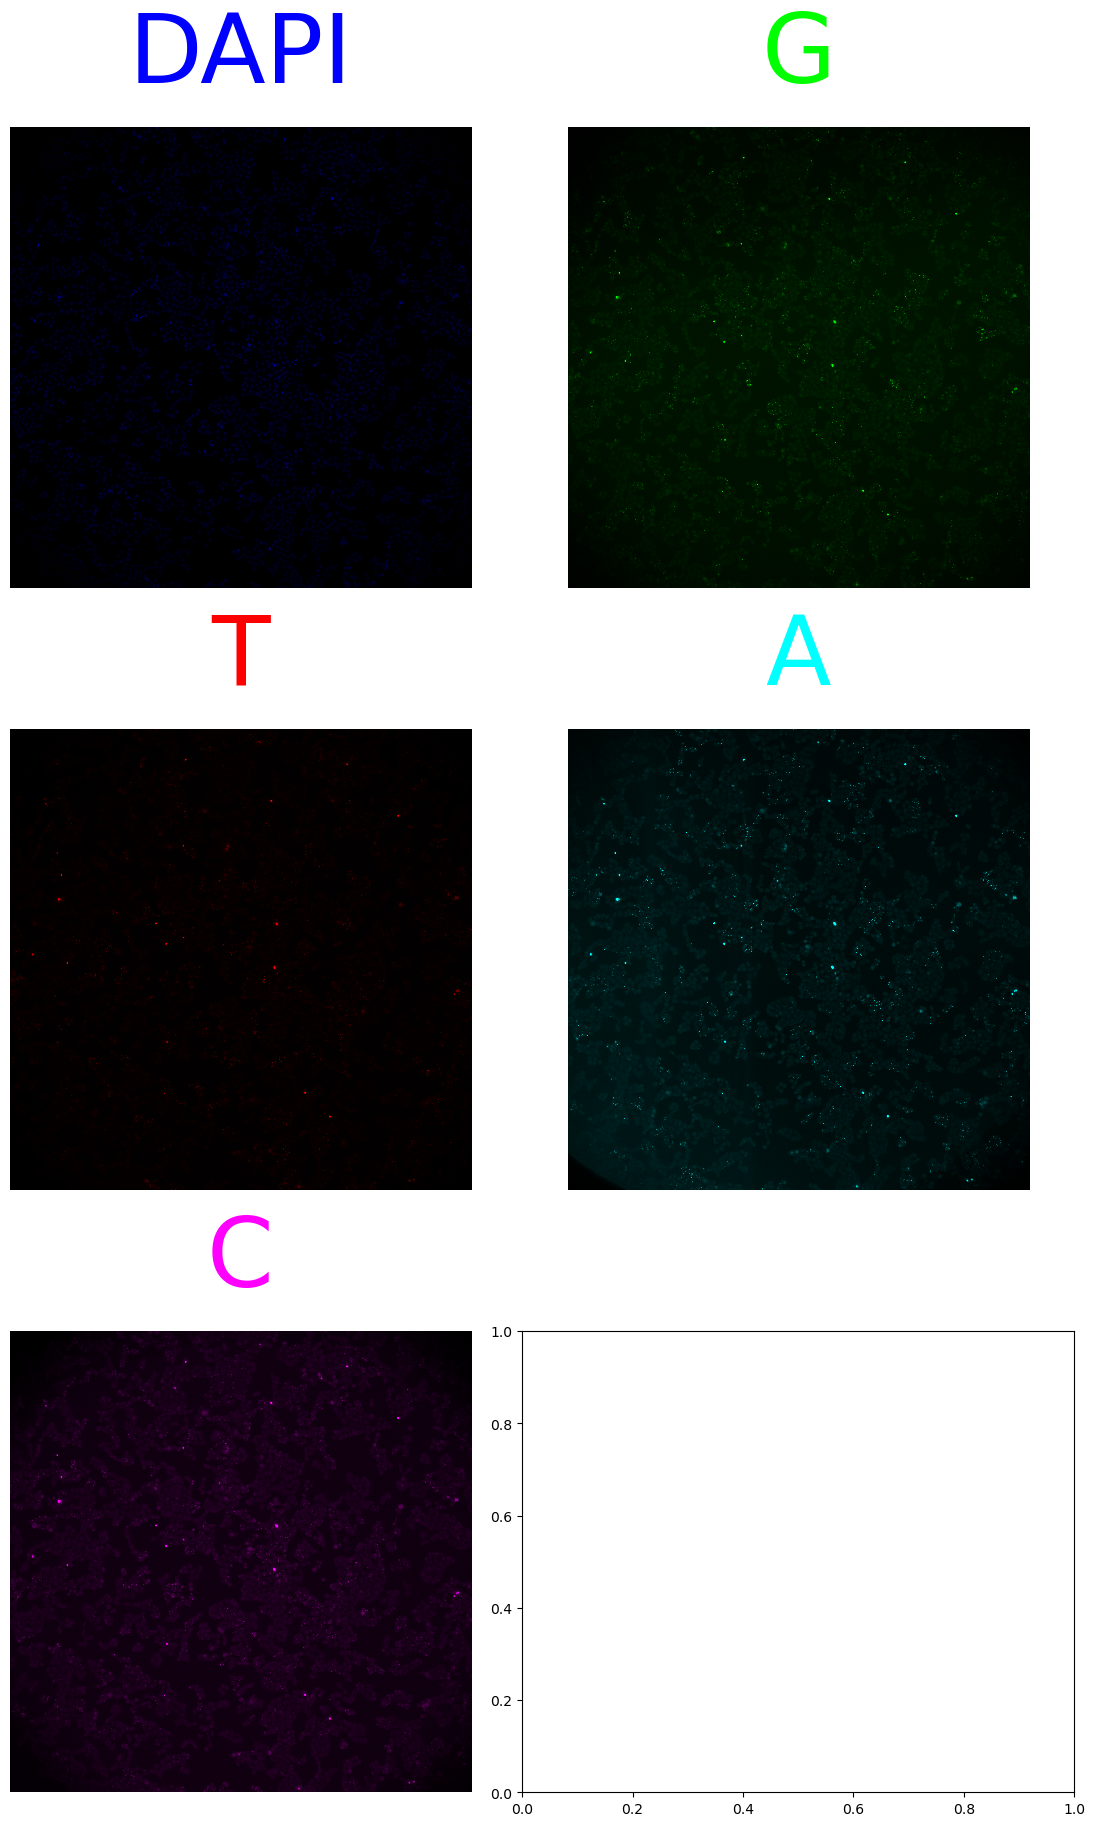

In [5]:
# load config file
with open(CONFIG_FILE_PATH, "r") as config_file:
    config = yaml.safe_load(config_file)

# Get paths to the sample files dfs
SBS_SAMPLES_FP = Path(config["preprocess"]["sbs_samples_fp"])
# Load the sample TSV files with pandas
sbs_samples = pd.read_csv(SBS_SAMPLES_FP, sep="\t")
SBS_CYCLES = sorted(list(sbs_samples["cycle"].unique()))

# load test image data
print("Loading test images...")
ROOT_FP = Path(config["all"]["root_fp"])
PREPROCESS_FP = ROOT_FP / "preprocess"
sbs_test_image_paths = expand(
    PREPROCESS_FP
    / "images"
    / "sbs"
    / get_filename(
        {"plate": TEST_PLATE, "well": TEST_WELL, "tile": TEST_TILE, "cycle": "{cycle}"},
        "image",
        "tiff",
    ),
    cycle=SBS_CYCLES,
)
sbs_test_images = [imread(file_path) for file_path in sbs_test_image_paths]


# align cycles
print("Aligning test images...")
aligned = align_cycles(
    sbs_test_images,
    method=ALIGNMENT_METHOD,
    upsample_factor=1,
    keep_extras=KEEP_EXTRAS,
)

# Create and display micropanel of aligned images
print("Example aligned image for first cycle:")
aligned_microimages = [
    Microimage(
        aligned[0, i, :, :], channel_names=CHANNEL_NAMES[i], cmaps=CHANNEL_CMAPS[i]
    )
    for i in range(aligned.shape[1])
]
aligned_panel = create_micropanel(aligned_microimages, add_channel_label=True)
plt.show()

Detecting candidate reads...
Applying Laplacian-of-Gaussian (LoG) filter...
Computing standard deviation over cycles...
Applying max filter...
Finding peaks...
Example max filtered image for first cycle:


microplot.py (725): Ignoring specified arguments in this call because figure with num: 1 already exists


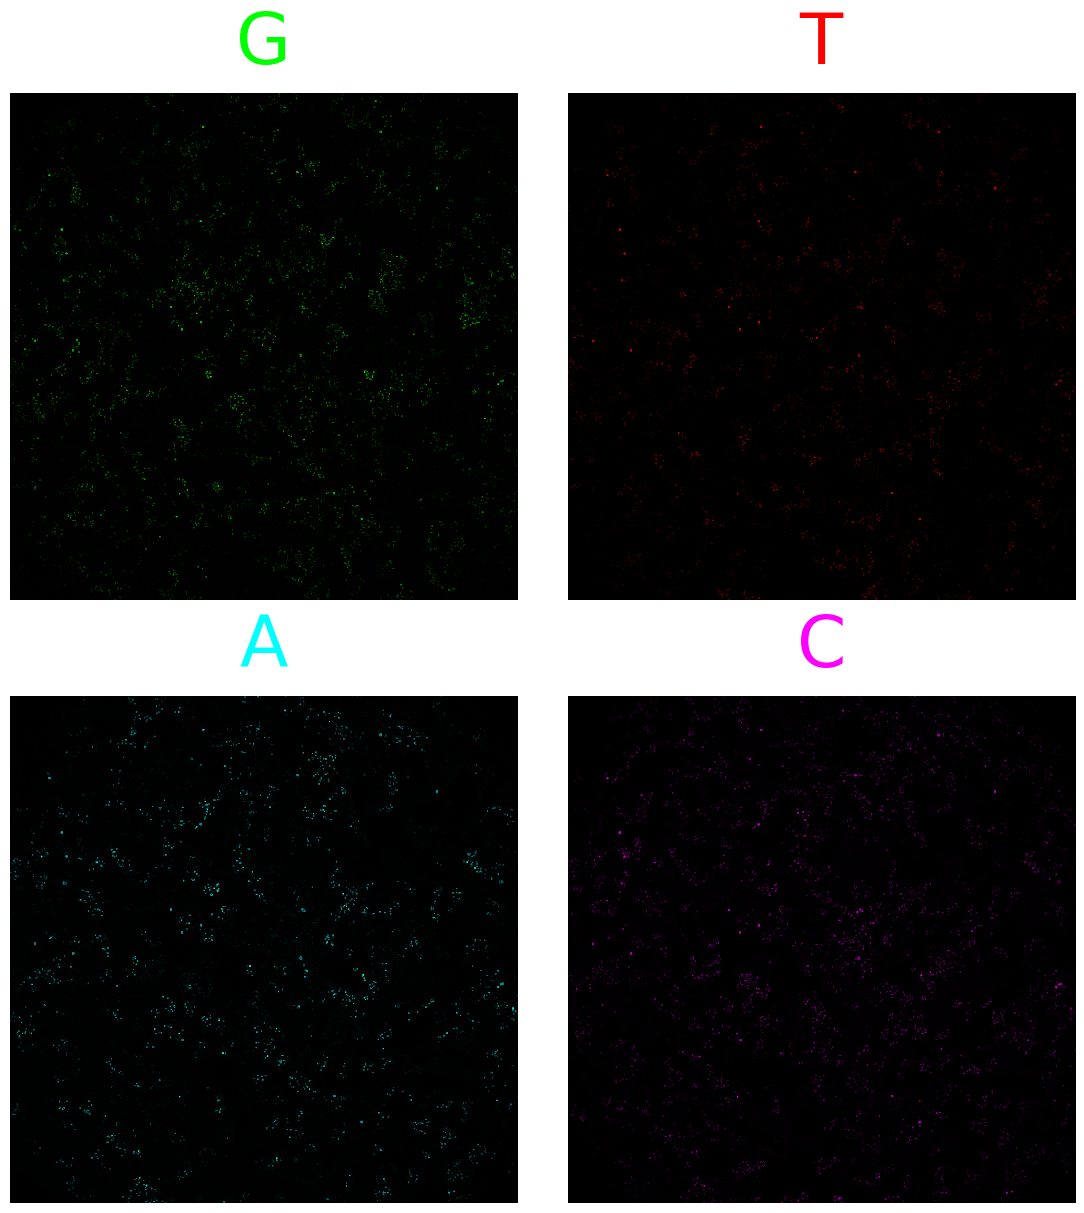

In [6]:
print("Detecting candidate reads...")

print("Applying Laplacian-of-Gaussian (LoG) filter...")
loged = log_filter(aligned, skip_index=0)

print("Computing standard deviation over cycles...")
standard_deviation = compute_standard_deviation(loged, remove_index=0)

print("Applying max filter...")
maxed = max_filter(loged, width=3, remove_index=0)

print("Finding peaks...")
peaks = find_peaks(standard_deviation)

# Create and display micropanel of max filtered datas
print("Example max filtered image for first cycle:")
maxed_microimages = [
    Microimage(maxed[0, i, :, :], channel_names=BASES[i], cmaps=CHANNEL_CMAPS[i + 1])
    for i in range(maxed.shape[1])
]
maxed_panel = create_micropanel(maxed_microimages, add_channel_label=True)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Illumination correction and Segmentation

- `SEGMENTATION_CYCLE`: Index of cycle used for illumination correction and segmentation. Typically, this is set to the cycle with the brightest or clearest signal for cell boundaries (there is often the most background signal in the last cycle, so that is often used).
- `CYTO_CHANNEL`: The name of the cytoplasmic channel in your image stack. Typically the channel that best outlines cell boundaries, usually base C.

In [7]:
# Define cycle to use for segmentation, -1 for last cycle
SEGMENTATION_CYCLE = 11
# Define cytoplasmic channel
CYTO_CHANNEL = "C"

# Derive DAPI and CYTO indexes
SEGMENTATION_CYCLE_INDEX = SBS_CYCLES.index(SEGMENTATION_CYCLE)
DAPI_INDEX = CHANNEL_NAMES.index("DAPI")
CYTO_INDEX = CHANNEL_NAMES.index(CYTO_CHANNEL)

Applying illumination correction to segmentation cycle image...
Preparing IC segmentation image for CellPose...
Pre-segmentation images:


dtype.py (576): Downcasting uint16 to uint8 without scaling because max value 0 fits in uint8


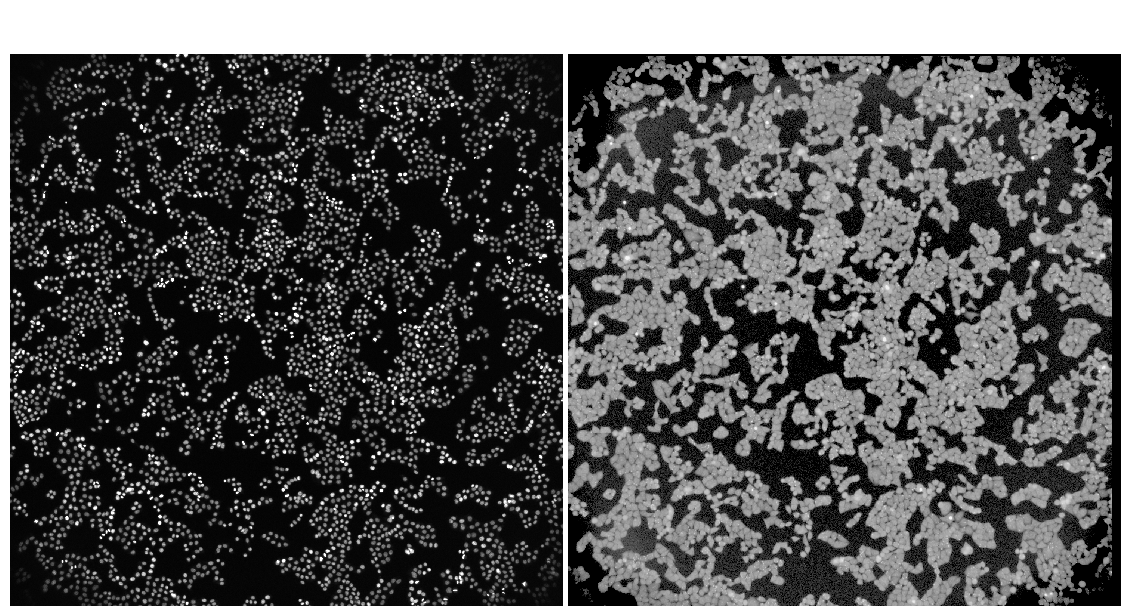

In [8]:
# Determine the cycle to use for segmentation
sbs_segmentation_cycle = SBS_CYCLES[SEGMENTATION_CYCLE_INDEX]
aligned_image_data_segmentation_cycle = aligned[SEGMENTATION_CYCLE_INDEX]

print("Applying illumination correction to segmentation cycle image...")
# Read the illumination correction file
if KEEP_EXTRAS:
    ic_field_dapi = imread(
        PREPROCESS_FP
        / "ic_fields"
        / "sbs"
        / get_filename(
            {"plate": TEST_PLATE, "well": TEST_WELL, "cycle": 1}, "ic_field", "tiff"
        )
    )
    ic_field_full = imread(
        PREPROCESS_FP
        / "ic_fields"
        / "sbs"
        / get_filename(
            {"plate": TEST_PLATE, "well": TEST_WELL, "cycle": sbs_segmentation_cycle},
            "ic_field",
            "tiff",
        )
    )
    ic_field = combine_ic_images([ic_field_dapi, ic_field_full], [DAPI_INDEX, None])
else:
    ic_field = imread(
        PREPROCESS_FP
        / "ic_fields"
        / "sbs"
        / get_filename(
            {"plate": TEST_PLATE, "well": TEST_WELL, "cycle": sbs_segmentation_cycle},
            "ic_field",
            "tiff",
        )
    )

# Apply illumination correction field
corrected_image_data = apply_ic_field(
    aligned_image_data_segmentation_cycle, correction=ic_field
)

# Prepare corrected image for CellPose segmentation
# NOTE: this process is done during the `segment_cellpose`` method below as well
# Use the prepared_cellpose image to test CellPose (see below)
print("Preparing IC segmentation image for CellPose...")
cellpose_rgb = prepare_cellpose(
    corrected_image_data,
    DAPI_INDEX,
    CYTO_INDEX,
)

# show max filtered data for one round
print("Pre-segmentation images:")
pre_seg_microimages = [
    Microimage(cellpose_rgb[2], channel_names="Dapi"),
    Microimage(cellpose_rgb[1], channel_names="Cyto"),
]
pre_seg_panel = create_micropanel(pre_seg_microimages, add_channel_label=True)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Segmentation

#### Select Segmentation Method
- `SEGMENTATION_METHOD`: Choose from "cellpose", "microsam", or "stardist" for cell segmentation.

#### Common Parameters
- `GPU`: Set to True to use GPU acceleration (if available)
- `RECONCILE`: Method for reconciling nuclei and cell masks (typically "contained_in_cells", which allows more than one nucleus per cell and is useful for cells that are dividing)

#### Cellpose Parameters (if using "cellpose")
- `CELLPOSE_MODEL`: CellPose model to use ("cyto", "cyto2", or "cyto3"). Default is "cyto3".
- `FLOW_THRESHOLD`: Flow threshold for Cellpose segmentation. Default is 0.4.
- `CELLPROB_THRESHOLD`: Cell probability threshold for Cellpose. Default is 0.
- Note: Nuclei and cell diameters will be estimated automatically.

#### MicroSAM Parameters (if using "microsam")
- `MICROSAM_MODEL`: MicroSAM model type. Default is "vit_b_lm".
- `POINTS_PER_SIDE`: Number of points to sample along each side of the image. Default is 32.
- `POINTS_PER_BATCH`: Number of points to process in one batch. Default is 16.
- `STABILITY_SCORE_THRESH`: Threshold for stability score. Default is 0.95.
- `PRED_IOU_THRESH`: Threshold for predicted IoU. Default is 0.88.

#### StarDist Parameters (if using "stardist")
- `STARDIST_MODEL`: StarDist model type. Default is "2D_versatile_fluo".
- `PROB_THRESH`: Probability threshold for segmentation. Default is 0.479071.
- `NMS_THRESH`: Non-maximum suppression threshold. Default is 0.3.

Note: You may want to adjust these parameters and run segmentation tests if you feel you are capturing too little or too much area for the masks. For cellpose, the nuclei and cell diameters will be automatically estimated, but can be manually adjusted if needed.

In [9]:
# Common parameters
GPU = False
RECONCILE = "contained_in_cells"

# Select segmentation method
SEGMENTATION_METHOD = "cellpose"

if SEGMENTATION_METHOD == "cellpose":
    # Parameters for CellPose method
    CELLPOSE_MODEL = "cyto3"
    FLOW_THRESHOLD = 0.4
    CELLPROB_THRESHOLD = 0

    print("Estimating optimal cell and nuclei diameters...")
    NUCLEI_DIAMETER, CELL_DIAMETER = estimate_diameters(
        corrected_image_data,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        cyto_model=CELLPOSE_MODEL,
    )

elif SEGMENTATION_METHOD == "microsam":
    # Parameters for MicroSAM method
    MICROSAM_MODEL = "vit_b_lm"
    POINTS_PER_SIDE = 32
    POINTS_PER_BATCH = 16
    STABILITY_SCORE_THRESH = 0.95
    PRED_IOU_THRESH = 0.88

elif SEGMENTATION_METHOD == "stardist":
    # Parameters for StarDist method
    STARDIST_MODEL = "2D_versatile_fluo"
    PROB_THRESH = 0.479071
    NMS_THRESH = 0.3

INFO:cellpose.core:>>>> using CPU
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.models:>> nuclei << model set to be used


Estimating optimal cell and nuclei diameters...
Estimating nuclei diameters...


INFO:cellpose.models:>>>> loading model /home/mdiberna/.cellpose/models/nucleitorch_0
INFO:cellpose.models:>>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.models:>> cyto3 << model set to be used
INFO:cellpose.models:>>>> loading model /home/mdiberna/.cellpose/models/cyto3


Estimated nuclear diameter: 9.4 pixels
Estimating cell diameters...


INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)


Estimated cell diameter: 18.8 pixels


Segmenting image with cellpose...


INFO:cellpose.core:>>>> using CPU
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.models:>> nuclei << model set to be used
INFO:cellpose.models:>>>> loading model /home/mdiberna/.cellpose/models/nucleitorch_0
INFO:cellpose.models:>>>> model diam_mean =  17.000 (ROIs rescaled to this size during training)
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.core:>>>> using CPU
INFO:cellpose.models:>> cyto3 << model set to be used
INFO:cellpose.models:>>>> loading model /home/mdiberna/.cellpose/models/cyto3
INFO:cellpose.models:>>>> model diam_mean =  30.000 (ROIs rescaled to this size during training)
INFO:cellpose.models:channels set to [3, 0]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 138.09 sec
INFO:cellpose.models:channels set to [2, 3]
INFO:cellpose.models:~~~ FINDING MASKS ~~~
INFO:cellpose.models:>>>> TOTAL TIME 115.27 sec
found 4382 nuclei before removing edges
found 4194 cells before removing edges
found 4287 nuclei before reconciling
found 4118 

removing edges
reconciling masks with method how=contained_in_cells

Nuclei per cell statistics:
--------------------------
Cells with 0 nuclei: 15
Cells with 1 nuclei: 4024
Cells with 2 nuclei: 71
Cells with 3 nuclei: 8
--------------------------



found 4103 nuclei/cells after reconciling


Number of nuclei segmented: 4103
Number of cells segmented: 4103
Example microplots for DAPI channel and nuclei segmentation:


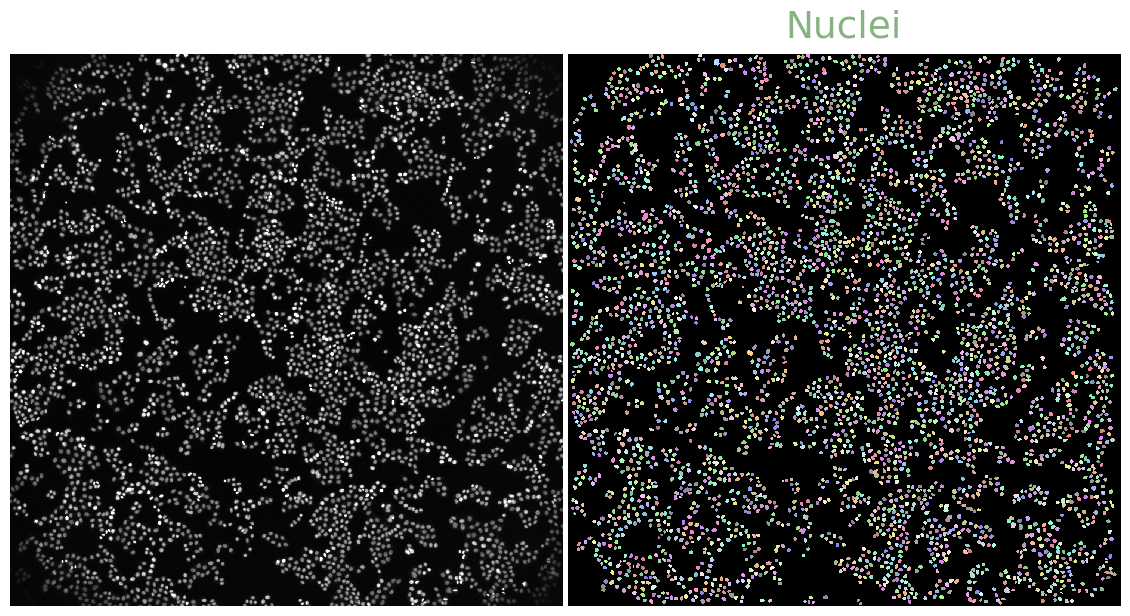

Example microplots for merged channels and cells segmentation:


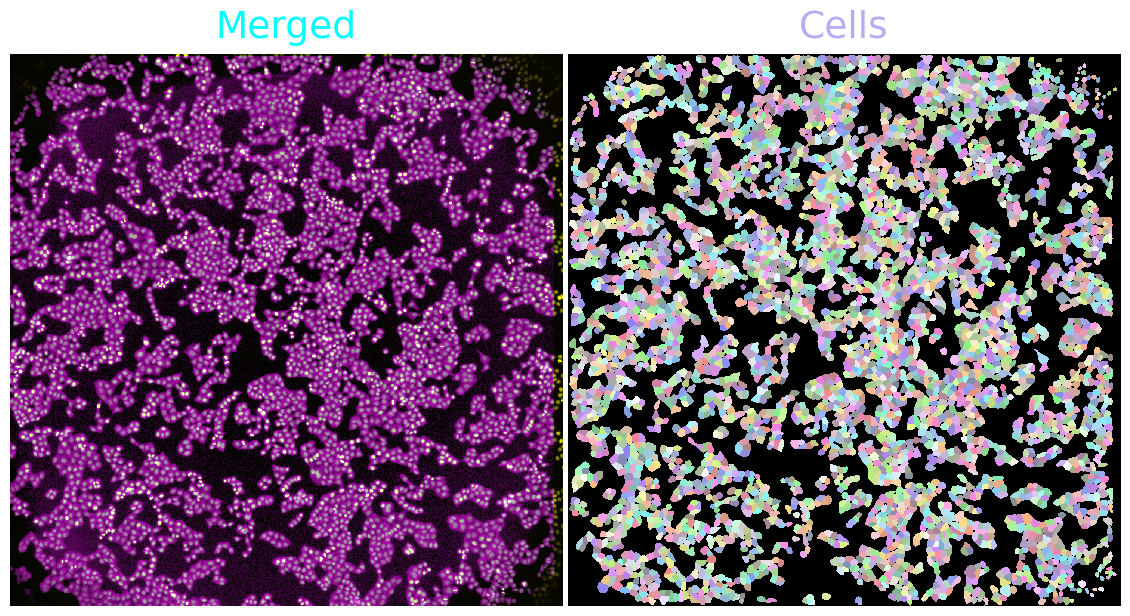

Example microplot for sequencing data annotated with segmentation:


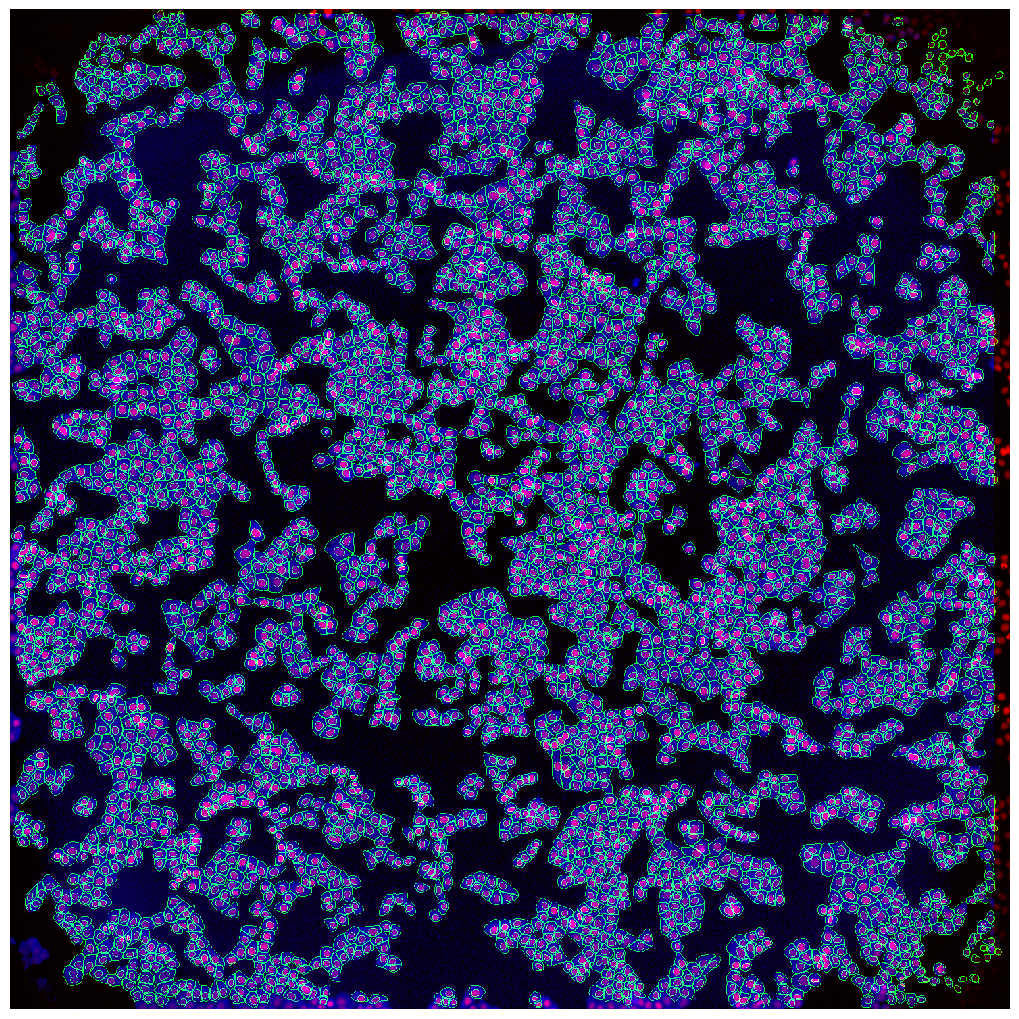

In [10]:
print(f"Segmenting image with {SEGMENTATION_METHOD}...")

if SEGMENTATION_METHOD == "cellpose":
    nuclei, cells = segment_cellpose(
        corrected_image_data,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        nuclei_diameter=NUCLEI_DIAMETER,
        cell_diameter=CELL_DIAMETER,
        cellpose_kwargs=dict(
            flow_threshold=FLOW_THRESHOLD,
            cellprob_threshold=CELLPROB_THRESHOLD,
        ),
        cyto_model=CELLPOSE_MODEL,
        gpu=GPU,
        reconcile=RECONCILE,
    )

elif SEGMENTATION_METHOD == "microsam":
    nuclei, cells = segment_microsam(
        corrected_image_data,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=MICROSAM_MODEL,
        microsam_kwargs=dict(
            points_per_side=POINTS_PER_SIDE,
            points_per_batch=POINTS_PER_BATCH,
            stability_score_thresh=STABILITY_SCORE_THRESH,
            pred_iou_thresh=PRED_IOU_THRESH,
        ),
        gpu=GPU,
        reconcile=RECONCILE,
    )

elif SEGMENTATION_METHOD == "stardist":
    nuclei, cells = segment_stardist(
        corrected_image_data,
        dapi_index=DAPI_INDEX,
        cyto_index=CYTO_INDEX,
        model_type=STARDIST_MODEL,
        stardist_kwargs=dict(
            prob_thresh=PROB_THRESH,
            nms_thresh=NMS_THRESH,
        ),
        gpu=GPU,
        reconcile=RECONCILE,
    )


# Create and display micropanel of nuclei segmention
print("Example microplots for DAPI channel and nuclei segmentation:")
nuclei_cmap = random_cmap(num_colors=len(np.unique(nuclei)))
nuclei_seg_microimages = [
    Microimage(cellpose_rgb[2], channel_names="Dapi"),
    Microimage(nuclei, cmaps=nuclei_cmap, channel_names="Nuclei"),
]
nuclei_seg_panel = create_micropanel(nuclei_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of segmented cells
print("Example microplots for merged channels and cells segmentation:")
cells_cmap = random_cmap(num_colors=len(np.unique(cells)))
cells_seg_microimages = [
    Microimage(cellpose_rgb, channel_names="Merged"),
    Microimage(cells, cmaps=cells_cmap, channel_names="Cells"),
]
cells_seg_panel = create_micropanel(cells_seg_microimages, add_channel_label=True)
plt.show()

# Create and display micropanel of annotated data
print("Example microplot for sequencing data annotated with segmentation:")
annotated_data = image_segmentation_annotations(cellpose_rgb[1:], nuclei, cells)
annotated_microimage = [
    Microimage(
        annotated_data,
        channel_names="Merged",
        cmaps=["pure_blue", "pure_red", "pure_green"],
    )
]
annotated_panel = create_micropanel(
    annotated_microimage, num_cols=1, figscaling=10, add_channel_label=False
)
plt.show()

## <font color='red'>SET PARAMETERS</font>

### Extract base intensity, call reads, assign to cells

- `DF_DESIGN_PATH`: The path to your guide RNA design file.
- `THRESHOLD_READS`: Initial threshold for detecting sequencing reads, set to 0 for preliminary analysis. This parameter will be optimized based on the mapping rate vs. peak threshold plot generated below. A higher threshold increases confidence in read calls but reduces the total number of detected reads.

In [11]:
# Define parameters for extracting bases
DF_DESIGN_PATH = "config/pool10_design.tsv"
THRESHOLD_READS = 50

In [12]:
# Read and format guide data
df_design = pd.read_csv(DF_DESIGN_PATH, sep="\t")
df_pool = df_design.query("dialout==[0,1]").drop_duplicates("sgRNA")
df_pool["prefix"] = df_pool.apply(lambda x: x.sgRNA[: x.prefix_length], axis=1)
barcodes = df_pool["prefix"]

# Run extract_bases and call_reads with the default threshold
df_bases = extract_bases(
    peaks, maxed, cells, THRESHOLD_READS, wildcards=WILDCARDS, bases=BASES
)
df_reads = call_reads(df_bases, peaks_data=peaks)

extract_bases.py (134): The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.


The following plots will help determine the optimal `THRESHOLD_READS` value for your data:

Mapping rate vs. peak threshold for determining optimal peak cutoff:


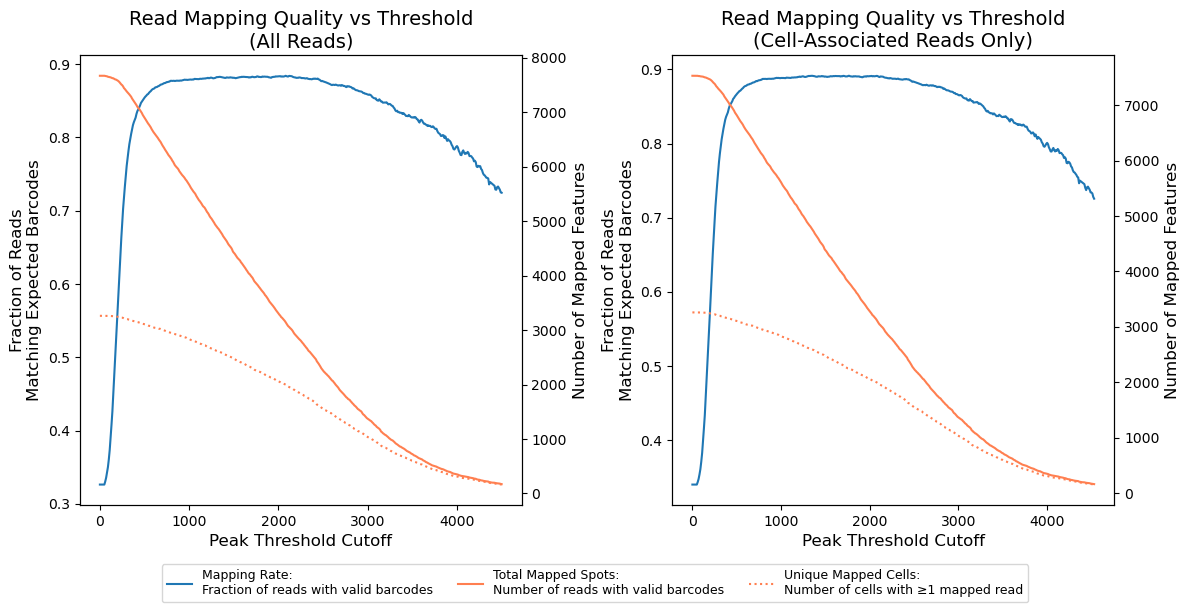

In [16]:
print("Mapping rate vs. peak threshold for determining optimal peak cutoff:")
plot_mapping_vs_threshold(df_reads, barcodes, "peak")
plt.show()

#### Left Plot (All Reads):
- Shows how the peak threshold affects all detected reads
- Blue line: Mapping rate (fraction of reads matching expected barcodes)
- Solid orange line: Total number of mapped spots (reads with valid barcodes)
- Dotted orange line: Number of unique cells with at least one mapped read

#### Right Plot (Cell-Associated Reads Only):
- Shows the same metrics but only for reads associated with cells

#### Setting Threshold Peaks:
Look for the point where the blue line (mapping rate) begins to plateau (~400)
- Consider the trade-off with number of mapped spots and cells
- A threshold around 300-500 typically provides a good balance:
  - Achieves ~75% mapping rate
  - Retains a reasonable number of mapped spots
  - Maintains coverage across cells

In [17]:
THRESHOLD_READS = 350

Extracted bases:


extract_bases.py (134): The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.


read  cycle channel  intensity  cell     i    j  tile well
0          0      1       G        525     0     5  443    50   A1
1          0      1       T        508     0     5  443    50   A1
2          0      1       A        788     0     5  443    50   A1
3          0      1       C       1466     0     5  443    50   A1
4          0      2       G          0     0     5  443    50   A1
...      ...    ...     ...        ...   ...   ...  ...   ...  ...
397843  9041     10       C       7520  4103  1472  777    50   A1
397844  9041     11       G        445  4103  1472  777    50   A1
397845  9041     11       T        295  4103  1472  777    50   A1
397846  9041     11       A       1850  4103  1472  777    50   A1
397847  9041     11       C       7294  4103  1472  777    50   A1

[398464 rows x 9 columns]

Base intensity across cycles:


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


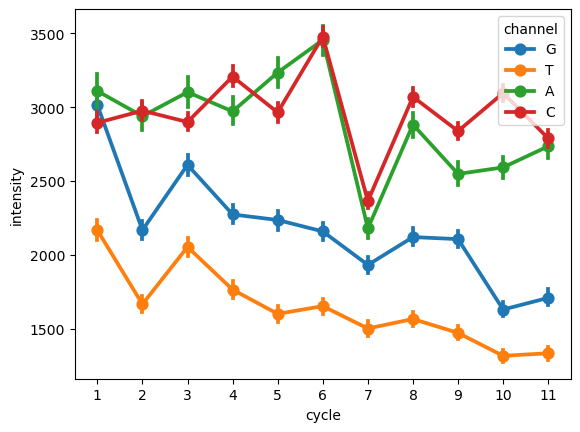

Intensity for each base:


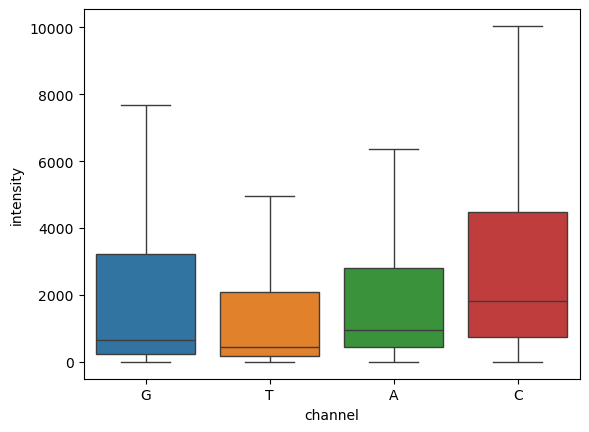

Called reads:


read  cell     i     j  tile well      barcode      Q_0  Q_1  \
2          0     0     5   443    50   A1  CACCACCCGGG  0.00000  0.0   
46         1     0     5   449    50   A1  GACCACCCTGG  0.73814  0.0   
90         2     0     5   497    50   A1  AACAACCAGGG  0.00000  0.0   
134        3     0     5   571    50   A1  AACCCCCCGGG  0.00000  0.0   
178        4     0     5   601    50   A1  AACAACCCGGG  0.00000  0.0   
...      ...   ...   ...   ...   ...  ...          ...      ...  ...   
397586  9036  4100  1471   651    50   A1  CACCATAGTTC  1.00000  1.0   
396222  9005  4102  1466  1156    50   A1  TATTAGGTAAC  1.00000  1.0   
397894  9043  4102  1472  1153    50   A1  TATTAGGTAAC  1.00000  1.0   
397234  9028  4103  1470   785    50   A1  CACTCACCACC  1.00000  1.0   
397806  9041  4103  1472   777    50   A1  CACTCACCACC  1.00000  1.0   

             Q_2       Q_3       Q_4       Q_5       Q_6       Q_7       Q_8  \
2       0.277294  0.277294  0.000000  0.452589  0.277294  0.452589  0.415037   
46      0.000000  0.000000  0.000000  0.277294  0.000000  0.000000  0.277294   
90      0.000000  0.000000  0.000000  0.415037  0.415037  0.000000  0.415037   
134     0.000000  0.415037  0.415037  0.277294  0.415037  0.000000  1.000000   
178     0.000000  0.000000  0.000000  0.415037  0.415037  0.415037  1.000000   
...          ...       ...       ...       ...       ...       ...       ...   
397586  1.000000  1.000000  1.000000  1.000000  1.000000  0.795880  1.000000   
396222  1.000000  1.000000  1.000000  1.000000  0.870850  1.000000  1.000000   
397894  1.000000  1.000000  1.000000  0.870850  0.415037  0.870850  1.000000   
397234  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
397806  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   

             Q_9     Q_10     Q_min         peak  
2       1.000000  1.00000  0.000000   823.443012  
46      1.000000  1.00000  0.000000   671.351176  
90      1.000000  0.73814  0.000000   469.440501  
134     1.000000  1.00000  0.000000   614.008305  
178     1.000000  1.00000  0.000000   407.143688  
...          ...      ...       ...          ...  
397586  1.000000  1.00000  0.795880  1814.151582  
396222  1.000000  1.00000  0.870850  1260.682729  
397894  0.415037  1.00000  0.415037  1001.861320  
397234  1.000000  1.00000  1.000000  2001.853390  
397806  1.000000  1.00000  1.000000  2088.169619  

[9056 rows x 20 columns]

In [18]:
# Re-run extract_bases and call_reads with the new threshold
print("Extracted bases:")
df_bases = extract_bases(
    peaks, maxed, cells, THRESHOLD_READS, wildcards=WILDCARDS, bases=BASES
)
display(df_bases)

print("Base intensity across cycles:")
ax = sns.pointplot(x="cycle", y="intensity", hue="channel", data=df_bases)
plt.show()

print("Intensity for each base:")
ax = sns.boxplot(
    x="channel", y="intensity", hue="channel", data=df_bases, showfliers=False
)
plt.show()

print("Called reads:")
df_reads = call_reads(df_bases, peaks_data=peaks)
display(df_reads)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

from lib.sbs.call_reads import (
    dataframe_to_values,
    transform_medians, 
    transform_percentiles,
    clean_up_bases,
    normalize_bases
)

def plot_normalization_comparison(df_bases, 
                                             base_pairs=[('C', 'A'), ('T', 'G')], 
                                             filter_to_compared_bases=True,
                                             base_order=["G", "T", "A", "C"]):
    """
    Compare raw, median and percentile normalization with all cycles combined
    
    Args:
        df_bases: DataFrame containing raw base intensities from extract_bases
        base_pairs: List of tuples representing base pairs to compare
        filter_to_compared_bases: If True, only show points where one of the compared bases was called
        base_order: List specifying the order of bases in the channel dimension (default: ["G", "T", "A", "C"])
        
    Returns:
        fig: Matplotlib figure with comparison plots
    """
    # First, clean up the bases data
    df_bases_clean = clean_up_bases(df_bases)
    
    # Create figure with subplots - 3 rows (normalization methods) x 2 columns (base pairs)
    fig, axes = plt.subplots(3, 2, figsize=(14, 18))
    
    # Get channel indices based on the specified base order
    channel_to_idx = {base: idx for idx, base in enumerate(base_order)}
    
    # Define base colors - keep the original colors
    base_colors = {'G': 'purple', 'T': 'cyan', 'A': 'green', 'C': 'red'}
    
    # Process the raw data
    for bp_idx, (base1, base2) in enumerate(base_pairs):
        # Filter the data for the relevant base pairs
        df_base1 = df_bases_clean[df_bases_clean['channel'] == base1][['read', 'cycle', 'intensity']]
        df_base2 = df_bases_clean[df_bases_clean['channel'] == base2][['read', 'cycle', 'intensity']]
        
        # Merge the two dataframes to get paired intensities
        df_merged = pd.merge(
            df_base1, 
            df_base2, 
            on=['read', 'cycle'], 
            suffixes=('_'+base1, '_'+base2)
        )
        
        # Get max intensities for base calling coloring
        all_bases = base_order.copy()  # Use the custom base order
        df_max = None
        
        for base in all_bases:
            df_temp = df_bases_clean[df_bases_clean['channel'] == base][['read', 'cycle', 'intensity']]
            df_temp = df_temp.rename(columns={'intensity': 'intensity_'+base})
            
            if df_max is None:
                df_max = df_temp
            else:
                df_max = pd.merge(df_max, df_temp, on=['read', 'cycle'])
        
        # Determine which base has max intensity for each read/cycle
        for base in all_bases:
            if base == all_bases[0]:
                df_max['max_base'] = base
                df_max['max_intensity'] = df_max['intensity_'+base]
            else:
                mask = df_max['intensity_'+base] > df_max['max_intensity']
                df_max.loc[mask, 'max_base'] = base
                df_max.loc[mask, 'max_intensity'] = df_max['intensity_'+base]
        
        # Merge with the paired data
        df_merged = pd.merge(df_merged, df_max[['read', 'cycle', 'max_base']], on=['read', 'cycle'])
        
        # Plot raw data (first row)
        ax = axes[0, bp_idx]
        
        # Filter to only show the compared bases if requested
        if filter_to_compared_bases:
            plot_bases = [base1, base2]
        else:
            plot_bases = all_bases
        
        for base in plot_bases:
            mask = df_merged['max_base'] == base
            if mask.any():
                ax.scatter(
                    df_merged.loc[mask, 'intensity_'+base2],
                    df_merged.loc[mask, 'intensity_'+base1],
                    color=base_colors[base],
                    alpha=0.5,
                    s=10,
                    label=f"'{base}' base call"
                )
        
        title_suffix = " (filtered)" if filter_to_compared_bases else ""
        ax.set_title(f"All Cycles: {base1}-{base2} (Raw){title_suffix}")
        ax.set_xlabel(base2)
        ax.set_ylabel(base1)
        
        # Now process for median and percentile normalization
        # First get all base intensities for each read/cycle
        data_all = df_bases_clean.pivot_table(
            index=['read', 'cycle'], 
            columns='channel', 
            values='intensity',
            aggfunc='first'
        ).reset_index()
        
        # Make sure all bases are present in data_all
        for base in all_bases:
            if base not in data_all.columns:
                data_all[base] = 0
        
        # Convert to numpy array for normalization functions (ensure correct order)
        X = data_all[all_bases].values
        
        # Apply median normalization
        # First normalize bases
        df_bases_norm = normalize_bases(df_bases_clean)
        X_norm = dataframe_to_values(df_bases_norm)
        Y_median, W_median = transform_medians(X_norm.reshape(-1, len(all_bases)))
        
        # Apply percentile normalization
        Y_percentile, W_percentile = transform_percentiles(X.reshape(-1, len(all_bases)))
        
        # Add normalized values back to the dataframe
        data_all['median_'+base1] = Y_median[:, channel_to_idx[base1]]
        data_all['median_'+base2] = Y_median[:, channel_to_idx[base2]]
        data_all['percentile_'+base1] = Y_percentile[:, channel_to_idx[base1]]
        data_all['percentile_'+base2] = Y_percentile[:, channel_to_idx[base2]]
        
        # Determine max channel after normalization
        for method in ['median', 'percentile']:
            values = Y_median if method == 'median' else Y_percentile
            max_indices = np.argmax(values, axis=1)
            data_all[method+'_max_base'] = [all_bases[i] for i in max_indices]
        
        # Plot median normalized data (second row)
        ax = axes[1, bp_idx]
        
        # Filter to only show the compared bases if requested
        if filter_to_compared_bases:
            plot_bases = [base1, base2]
        else:
            plot_bases = all_bases
        
        for base in plot_bases:
            mask = data_all['median_max_base'] == base
            if mask.any():
                ax.scatter(
                    data_all.loc[mask, 'median_'+base2],
                    data_all.loc[mask, 'median_'+base1],
                    color=base_colors[base],
                    alpha=0.5,
                    s=10,
                    label=f"'{base}' base call"
                )
        
        # Add diagonal reference line
        max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.7)
        
        ax.set_title(f"All Cycles: {base1}-{base2} (Median){title_suffix}")
        ax.set_xlabel(base2)
        ax.set_ylabel(base1)
        
        # Plot percentile normalized data (third row)
        ax = axes[2, bp_idx]
        
        # Filter to only show the compared bases if requested
        if filter_to_compared_bases:
            plot_bases = [base1, base2]
        else:
            plot_bases = all_bases
        
        for base in plot_bases:
            mask = data_all['percentile_max_base'] == base
            if mask.any():
                ax.scatter(
                    data_all.loc[mask, 'percentile_'+base2],
                    data_all.loc[mask, 'percentile_'+base1],
                    color=base_colors[base],
                    alpha=0.5,
                    s=10,
                    label=f"'{base}' base call"
                )
        
        # Add diagonal reference line
        max_val = max(ax.get_xlim()[1], ax.get_ylim()[1])
        ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.7)
        
        ax.set_title(f"All Cycles: {base1}-{base2} (Percentile){title_suffix}")
        ax.set_xlabel(base2)
        ax.set_ylabel(base1)
    
    # Create a shared legend at the bottom
    # Choose which bases to show in the legend based on filter setting
    if filter_to_compared_bases:
        # Get unique bases from all base pairs
        legend_bases = set()
        for base1, base2 in base_pairs:
            legend_bases.add(base1)
            legend_bases.add(base2)
        legend_bases = sorted(legend_bases)
    else:
        legend_bases = sorted(all_bases)
    
    # Create legend elements
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor=base_colors[base],
               markersize=10, label=f"'{base}' base call")
        for base in legend_bases
    ]
    
    # Add diagonal line to legend if present in plots
    legend_elements.append(
        Line2D([0], [0], linestyle='--', color='k', 
               label="Diagonal reference (y=x)")
    )
    
    # Add legend at the bottom
    fig.legend(
        handles=legend_elements,
        loc='lower center',
        bbox_to_anchor=(0.5, 0.02),
        ncol=len(legend_elements),
        fontsize=12
    )
    
    # Adjust layout to make room for the legend
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.1)
    
    return fig

call_reads.py (333): invalid value encountered in divide
call_reads.py (333): invalid value encountered in divide


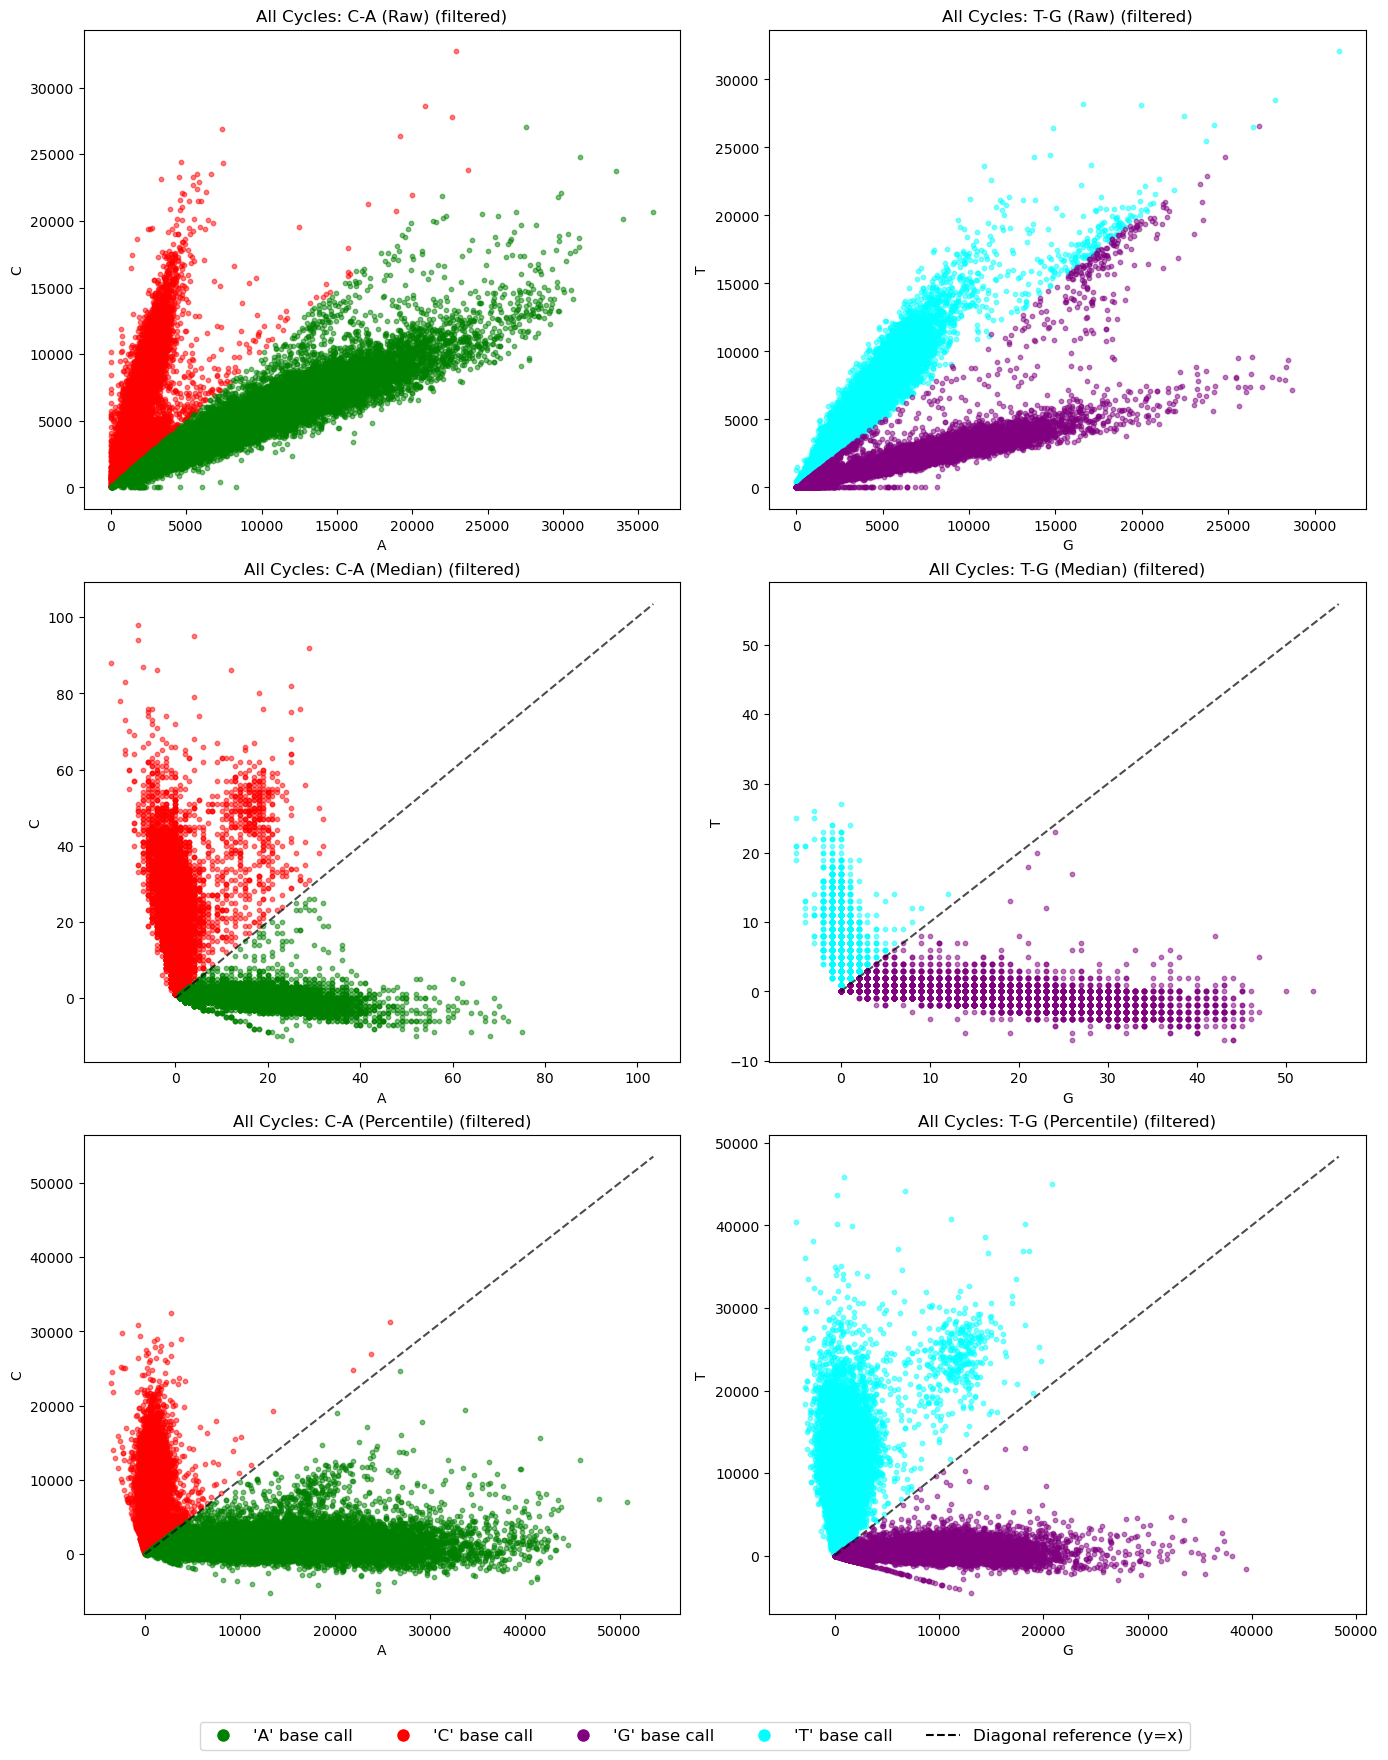

In [ ]:
fig = plot_normalization_comparison(df_bases, base_order = BASES)

## <font color='red'>SET PARAMETERS</font>

### Read mapping

- `Q_MIN`: The minimum quality score for each base read. Calculated as 1 - [log2(2 + second) / log2(2 + first)]. Default is 0 and typically remains unchanged. While the Q_min plot above shows the relationship between Q_min and mapping rate, adjusting THRESHOLD_READS is the preferred method for quality control. Higher Q_min values are more stringent but can excessively filter valid reads.

The following plots will help determine the optimal `Q_MIN` value for your data:

Mapping rate vs. Q_min for determining optimal sequence quality cutoff:


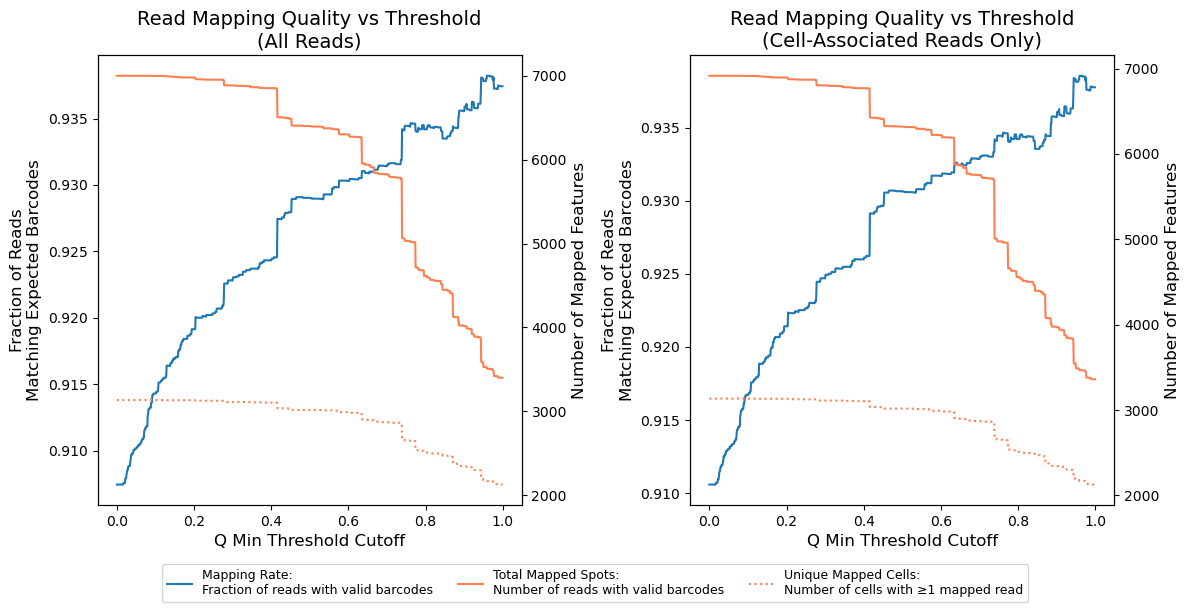

In [16]:
print("Mapping rate vs. Q_min for determining optimal sequence quality cutoff:")
plot_mapping_vs_threshold(df_reads, barcodes, "Q_min")
plt.show()

#### Left Plot (All Reads):
- Shows how Q_min threshold affects all detected reads
- Blue line: Mapping rate (fraction of reads matching expected barcodes)
- Solid red line: Total number of mapped spots (reads with valid barcodes)
- Dotted red line: Number of unique cells with at least one mapped read

#### Right Plot (Cell-Associated Reads Only):
- Shows the same metrics but only for reads associated with cells

#### Interpreting Q_min Results:
With our optimized peak threshold, these plots confirm that adjusting Q_min provides little benefit:
- The mapping rate (blue line) is already very high at Q_min = 0
- Increasing Q_min only marginally improves mapping rate 
- However, this comes at a significant cost:
  - Total mapped spots and mapped cells decreases substantially
- The small gain in mapping rate doesn't justify the large loss of data

In [17]:
# Define parameters for read mapping
Q_MIN = 0

Corrected cells:


cell  tile well       Q_0       Q_1       Q_2       Q_3       Q_4  \
0        1    50   A1  0.738140  1.000000  1.000000  1.000000  0.738140   
1        2    50   A1  0.738140  1.000000  1.000000  1.000000  0.738140   
2        3    50   A1  1.000000  0.000000  1.000000  1.000000  1.000000   
3        4    50   A1  1.000000  1.000000  1.000000  1.000000  1.000000   
4        5    50   A1  0.000000  0.000000  0.203511  0.345825  0.415037   
...    ...   ...  ...       ...       ...       ...       ...       ...   
3537  4096    50   A1  0.773706  0.415037  0.203511  1.000000  0.000000   
3538  4097    50   A1  1.000000  1.000000  1.000000  1.000000  1.000000   
3539  4100    50   A1  1.000000  1.000000  0.738140  0.415037  1.000000   
3540  4102    50   A1  1.000000  1.000000  1.000000  1.000000  1.000000   
3541  4103    50   A1  1.000000  1.000000  1.000000  1.000000  1.000000   

           Q_5       Q_6  ...  cell_barcode_count_0  cell_barcode_1  \
0     0.738140  1.000000  ...                     2     CGTACCTTGGA   
1     1.000000  1.000000  ...                     1             NaN   
2     1.000000  0.773706  ...                     1     AAAGACCGAAT   
3     1.000000  1.000000  ...                     5     TTGCTCTCTCA   
4     0.452048  0.000000  ...                     1     AAGCCCCCGCC   
...        ...       ...  ...                   ...             ...   
3537  0.415037  0.738140  ...                     2     TATGAGAAGCT   
3538  1.000000  1.000000  ...                     3             NaN   
3539  1.000000  0.415037  ...                     2             NaN   
3540  1.000000  0.870850  ...                     2             NaN   
3541  1.000000  1.000000  ...                     2             NaN   

      cell_barcode_count_1  barcode_count               sgRNA_0  \
0                      1.0              3  CTTACCTTGGAAGTGGACGT   
1                      0.0              1  CTTACCTTGGAAGTGGACGT   
2                      1.0              2  AGAGACCGAATAGGCACAGG   
3                      1.0              6  ACACTGTCCAGGACAACCTG   
4                      1.0              4  ACACTGTCCAGGACAACCTG   
...                    ...            ...                   ...   
3537                   1.0              3  CAAGAGAAGCCACTTACCTT   
3538                   0.0              3  TAATGTAAGTCATGTTAGTG   
3539                   0.0              2  CACCATAGTTCCGGACCCCG   
3540                   0.0              2  TATTAGGTAACCAATGGTCA   
3541                   0.0              2  CACTCACCACCACTGACTTG   

      gene_symbol_0 gene_id_0               sgRNA_1 gene_symbol_1  gene_id_1  
0               AGT       183                   NaN           NaN        NaN  
1               AGT       183                   NaN           NaN        NaN  
2            SMURF2     64750                   NaN           NaN        NaN  
3              LSP1      4046  TTGCTCTCTCACTGTTGTTA         UQCRH       7388  
4              LSP1      4046                   NaN           NaN        NaN  
...             ...       ...                   ...           ...        ...  
3537         UNC13A     23025                   NaN           NaN        NaN  
3538          STIP1     10963                   NaN           NaN        NaN  
3539           BCAN     63827                   NaN           NaN        NaN  
3540          SPAG9      9043                   NaN           NaN        NaN  
3541            PHB      5245                   NaN           NaN        NaN  

[3542 rows x 27 columns]

Minimal phenotype features:


area            i            j  cell                    bounds  tile  \
0      85.0    12.894118   241.200000     1         (8, 237, 19, 247)    50   
1      87.0     9.045977   252.885057     2         (3, 249, 16, 258)    50   
2      77.0     6.415584   353.493506     3         (2, 349, 12, 359)    50   
3     111.0    21.630631   431.945946     4        (16, 427, 28, 438)    50   
4     111.0    18.288288   446.981982     5        (12, 442, 25, 453)    50   
...     ...          ...          ...   ...                       ...   ...   
4098   70.0  1468.385714   644.414286  4099    (1464, 641, 1474, 649)    50   
4099   62.0  1469.370968   655.951613  4100    (1465, 652, 1474, 661)    50   
4100   74.0  1468.540541   914.040541  4101    (1464, 910, 1474, 919)    50   
4101   64.0  1470.671875  1156.875000  4102  (1466, 1153, 1476, 1162)    50   
4102   53.0  1473.000000   782.000000  4103    (1470, 778, 1477, 787)    50   

     well  
0      A1  
1      A1  
2      A1  
3      A1  
4      A1  
...   ...  
4098   A1  
4099   A1  
4100   A1  
4101   A1  
4102   A1  

[4103 rows x 7 columns]

Summary of the fraction of cells mapping to one barcode:


well  tile  fraction of cells mapping to 1 gene symbols
0   A1    50                                     0.676091

Summary of the fraction of cells mapping to any barcode:


well  tile  fraction of cells mapping to >=1 gene symbols
0   A1    50                                       0.771143

Histogram of the number of reads per cell:


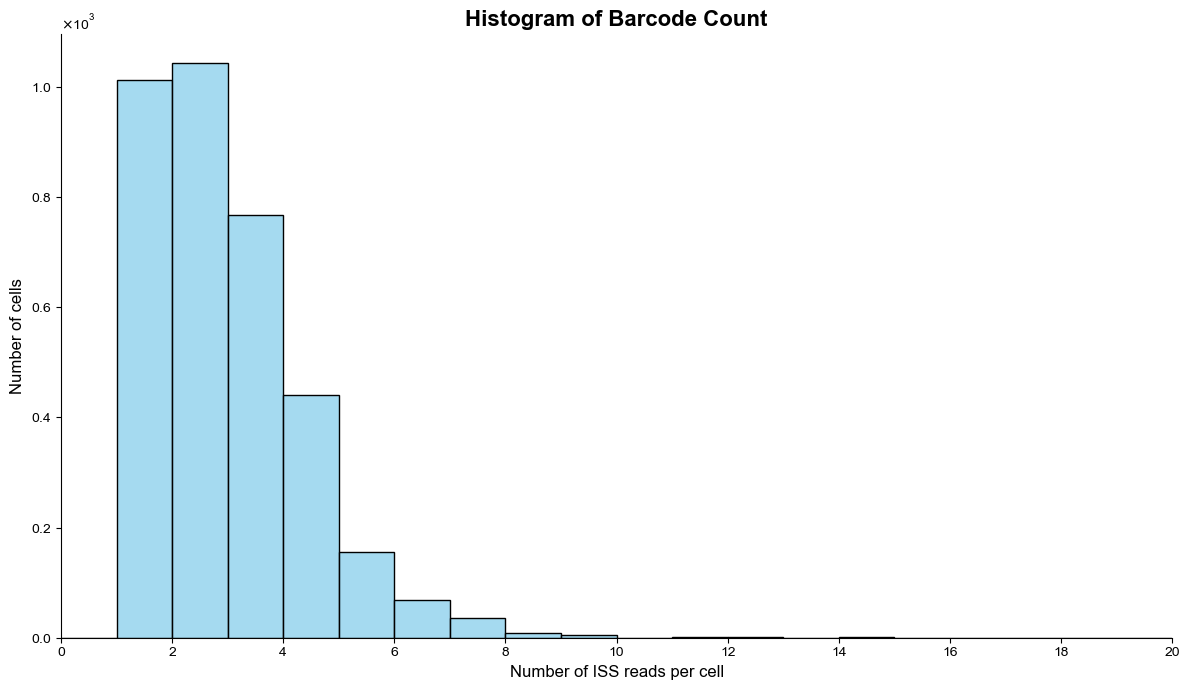

Histogram of the number of counts of each unique gene symbols:


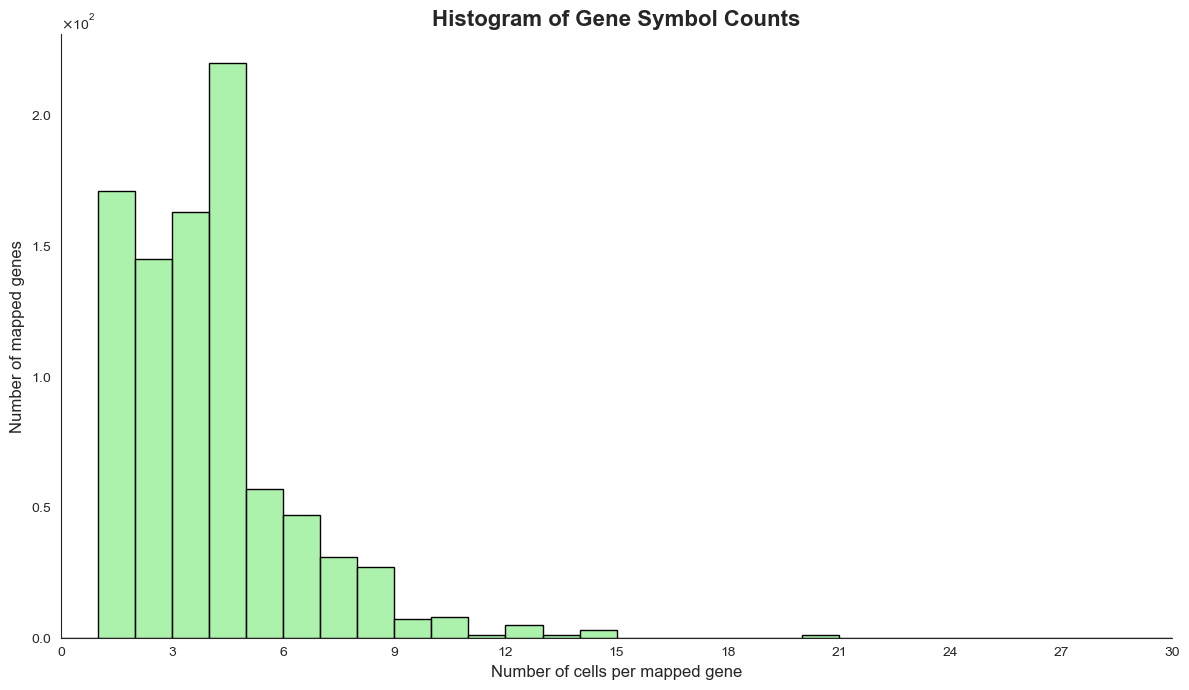

In [18]:
print("Corrected cells:")
df_cells = call_cells(df_reads, df_pool=df_pool, q_min=Q_MIN)
display(df_cells)

print("Minimal phenotype features:")
df_sbs_info = extract_phenotype_minimal(
    phenotype_data=nuclei, nuclei_data=nuclei, wildcards=WILDCARDS
)
display(df_sbs_info)

print("Summary of the fraction of cells mapping to one barcode:")
one_barcode_mapping = plot_cell_mapping_heatmap(
    df_cells,
    df_sbs_info,
    barcodes,
    mapping_to="one",
    mapping_strategy="gene symbols",
    shape="6W_sbs",
    return_plot=False,
    return_summary=True,
)
display(one_barcode_mapping)

print("Summary of the fraction of cells mapping to any barcode:")
any_barcode_mapping = plot_cell_mapping_heatmap(
    df_cells,
    df_sbs_info,
    barcodes,
    mapping_to="any",
    mapping_strategy="gene symbols",
    shape="6W_sbs",
    return_plot=False,
    return_summary=True,
)
display(any_barcode_mapping)

print("Histogram of the number of reads per cell:")
outliers = plot_reads_per_cell_histogram(df_cells, x_cutoff=20)
plt.show()

print("Histogram of the number of counts of each unique gene symbols:")
outliers = plot_gene_symbol_histogram(df_cells, x_cutoff=30)
plt.show()

## Add sbs process parameters to config file

The `mode` parameter in the config file determines how Snakemake will execute parameter searches for segmentation optimization. Setting the `mode` to `segment_sbs_paramsearch` will systematically explore combinations of:

1. Size Parameters:
   - `nuclei_diameter`: Expected diameter of cell nuclei
   - `cell_diameter`: Expected diameter of cell cytoplasm
   
2. CellPose Parameters:
   - `flow_threshold`: Controls sensitivity of segmentation boundaries (default value 0.4)
     - Lower values: More aggressive segmentation, may over-segment
     - Higher values: More conservative, may miss cell boundaries
   - `cellprob_threshold`: Controls cell detection confidence (default value 0)
     - Lower values: Detects more potential cells, may include false positives
     - Higher values: More stringent detection, may miss weaker signals

The parameter search will:
1. Generate segmentations using different parameter combinations
2. Save results for each combination
3. Allow you to visually inspect results to choose optimal values
4. Help identify the best balance between over- and under-segmentation

Running these parameter searches is a time and resource intensive process and should only be done on a small subset of the tiles in the dataset.

In [ ]:
# # Add sbs section
# config["sbs"] = {
#     "alignment_method": ALIGNMENT_METHOD,
#     "keep_extras": KEEP_EXTRAS,
#     "segmentation_cycle_index": SEGMENTATION_CYCLE_INDEX,
#     "dapi_index": DAPI_INDEX,
#     "cyto_index": CYTO_INDEX,
#     "threshold_peaks": THRESHOLD_READS,
#     "bases": BASES,
#     "df_design_path": DF_DESIGN_PATH,
#     "q_min": Q_MIN,
#     "reconcile": RECONCILE,
#     "gpu": GPU,
#     "mode": None,
# }

# # Add method-specific parameters based on segmentation method
# if SEGMENTATION_METHOD == "cellpose":
#     config["sbs"].update({
#         "cellpose_model": CELLPOSE_MODEL,
#         "nuclei_diameter": NUCLEI_DIAMETER,
#         "cell_diameter": CELL_DIAMETER,
#         "flow_threshold": FLOW_THRESHOLD,
#         "cellprob_threshold": CELLPROB_THRESHOLD,
#     })
# elif SEGMENTATION_METHOD == "microsam":
#     config["sbs"].update({
#         "microsam_model": MICROSAM_MODEL,
#         "points_per_side": POINTS_PER_SIDE,
#         "points_per_batch": POINTS_PER_BATCH,
#         "stability_score_thresh": STABILITY_SCORE_THRESH,
#         "pred_iou_thresh": PRED_IOU_THRESH,
#     })
# elif SEGMENTATION_METHOD == "stardist":
#     config["sbs"].update({
#         "stardist_model": STARDIST_MODEL,
#         "prob_thresh": PROB_THRESH,
#         "nms_thresh": NMS_THRESH,
#     })

# # Write the updated configuration back with markdown-style comments
# with open(CONFIG_FILE_PATH, "w") as config_file:
#     # Write the introductory markdown-style comments
#     config_file.write(CONFIG_FILE_HEADER)
    
#     # Dump the updated YAML structure, keeping markdown comments for sections
#     yaml.dump(config, config_file, default_flow_style=False)

In [22]:
from lib.shared.rule_utils import get_segmentation_params

segmentation_params = get_segmentation_params("sbs", config)

print(segmentation_params)

{'method': 'cellpose', 'dapi_index': 0, 'cyto_index': 4, 'reconcile': 'contained_in_cells', 'return_counts': True, 'gpu': False, 'cyto_model': 'cyto3', 'nuclei_diameter': 9.440697438826296, 'cell_diameter': 18.847647942942654, 'flow_threshold': 0.4, 'cellprob_threshold': 0}
